# Beijing Air Quality Forecasting Starter Notebook

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [15]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
df_train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


In [17]:
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

##  Initial Data Overview and Quality Assessment

In [18]:
# Basic information about the dataset
print("=== DATASET OVERVIEW ===")
print(f"Train Dataset shape: {df_train.shape}")
print(f"Test Dataset shape: {df_test.shape}")
print(f"Memory usage: {df_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n=== DATA TYPES ===")
print(df_train.dtypes)
print("\n=== BASIC STATISTICS ===")
df_train.describe()

=== DATASET OVERVIEW ===
Train Dataset shape: (30676, 12)
Test Dataset shape: (13148, 11)
Memory usage: 4.80 MB

=== DATA TYPES ===
No            int64
DEWP        float64
TEMP        float64
PRES        float64
Iws         float64
Is          float64
Ir          float64
datetime     object
cbwd_NW     float64
cbwd_SE     float64
cbwd_cv     float64
pm2.5       float64
dtype: object

=== BASIC STATISTICS ===


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


**Explanation:** Understanding data types and basic statistics is crucial for time series forecasting as it helps identify:

- Numerical vs categorical features that need different preprocessing
- Scale differences between features (important for neural networks)
- Potential outliers that could affect model training

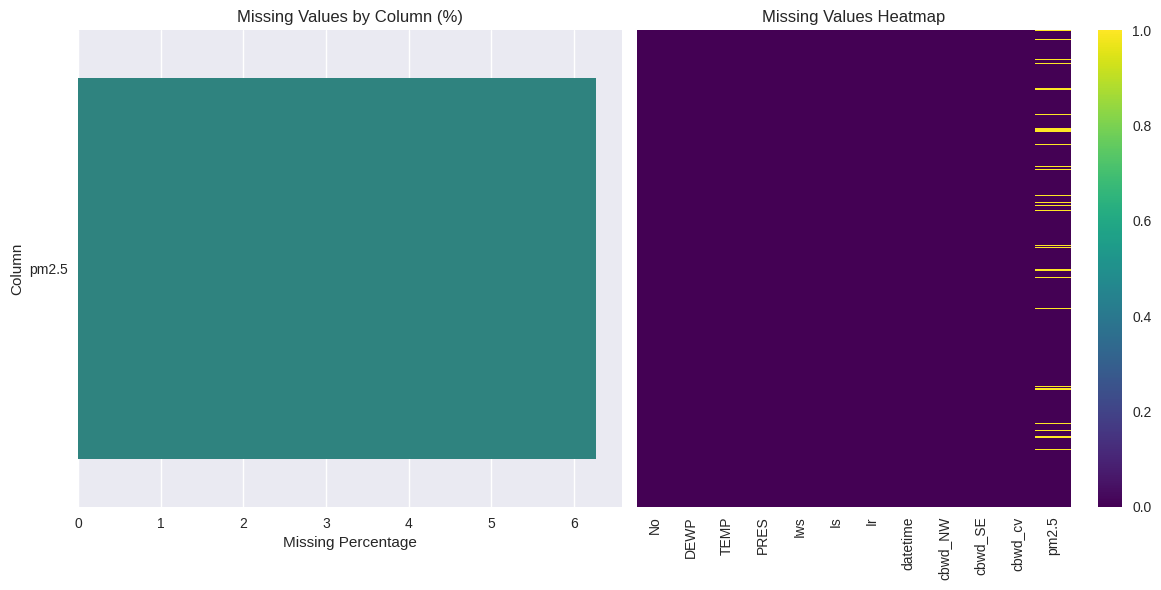

      Column  Missing_Count  Missing_Percentage
pm2.5  pm2.5           1921            6.262225


In [21]:
# Missing values analysis
def analyze_missing_values(df):
    missing_data = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
    })
    missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

    if len(missing_data) > 0:
        plt.figure(figsize=(12, 6))

        # Missing values bar plot
        plt.subplot(1, 2, 1)
        sns.barplot(data=missing_data, y='Column', x='Missing_Percentage', palette='viridis')
        plt.title('Missing Values by Column (%)')
        plt.xlabel('Missing Percentage')

        # Missing values heatmap
        plt.subplot(1, 2, 2)
        sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
        plt.title('Missing Values Heatmap')

        plt.tight_layout()
        plt.show()

        return missing_data
    else:
        print("No missing values found!")
        return pd.DataFrame()

missing_analysis = analyze_missing_values(df_train)
print(missing_analysis)

**Explanation:** Missing value analysis is critical for time series because:

- Gaps in time series can break temporal patterns
- Different imputation strategies affect forecasting accuracy
- Understanding missing data patterns helps choose appropriate handling methods (forward fill, interpolation, or removal)

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [22]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
df_train

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
30671,30672,1.467633,0.946961,-2.088668,-0.415099,-0.069353,2.687490,2013-07-01 23:00:00,-0.690542,-0.732019,-0.522096,50.0
30672,30673,1.329064,0.864984,-2.186052,-0.379306,-0.069353,3.393779,2013-07-02 00:00:00,1.448138,-0.732019,-0.522096,41.0
30673,30674,1.259780,0.701029,-2.088668,-0.263130,-0.069353,4.100068,2013-07-02 01:00:00,1.448138,-0.732019,-0.522096,32.0
30674,30675,1.190496,0.701029,-2.088668,-0.146953,-0.069353,4.806358,2013-07-02 02:00:00,1.448138,-0.732019,-0.522096,19.0


In [23]:
df_train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

# Datetime Processing

In [24]:
# Ensure 'datetime' column is in datetime format
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

df_test['datetime'] = pd.to_datetime(df_test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
df_train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
df_test.set_index('datetime', inplace=True)

# Handle missing values

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [25]:
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

# Temporal Features

In [26]:
# Get new featurs from the index
for df in [df_train, df_test]:
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week


for df in [df_train, df_test]:
    # Hour cyclical encoding (24-hour cycle)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

**Explanation:** Temporal feature engineering is essential because:

- Cyclical encoding (sin/cos) preserves periodic relationships (hour 23 is close to hour 0)
- Neural networks can better learn seasonal patterns with explicit temporal features
- Regular time intervals ensure consistent model input structure

In [27]:
df_train

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,...,hour,day_of_week,day_of_year,week_of_year,month_sin,month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,0,4,1,53,0.5,0.866025,0.000000,1.000000,-0.433884,-0.900969
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,1,4,1,53,0.5,0.866025,0.258819,0.965926,-0.433884,-0.900969
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,2,4,1,53,0.5,0.866025,0.500000,0.866025,-0.433884,-0.900969
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,3,4,1,53,0.5,0.866025,0.707107,0.707107,-0.433884,-0.900969
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,4,4,1,53,0.5,0.866025,0.866025,0.500000,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-01 23:00:00,30672,1.467633,0.946961,-2.088668,-0.415099,-0.069353,2.687490,-0.690542,-0.732019,-0.522096,...,23,0,182,27,-0.5,-0.866025,-0.258819,0.965926,0.000000,1.000000
2013-07-02 00:00:00,30673,1.329064,0.864984,-2.186052,-0.379306,-0.069353,3.393779,1.448138,-0.732019,-0.522096,...,0,1,183,27,-0.5,-0.866025,0.000000,1.000000,0.781831,0.623490
2013-07-02 01:00:00,30674,1.259780,0.701029,-2.088668,-0.263130,-0.069353,4.100068,1.448138,-0.732019,-0.522096,...,1,1,183,27,-0.5,-0.866025,0.258819,0.965926,0.781831,0.623490


# Target Variable (PM2.5) Analysis

In [29]:
print(df_train.columns.tolist())

['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_of_year', 'week_of_year', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']


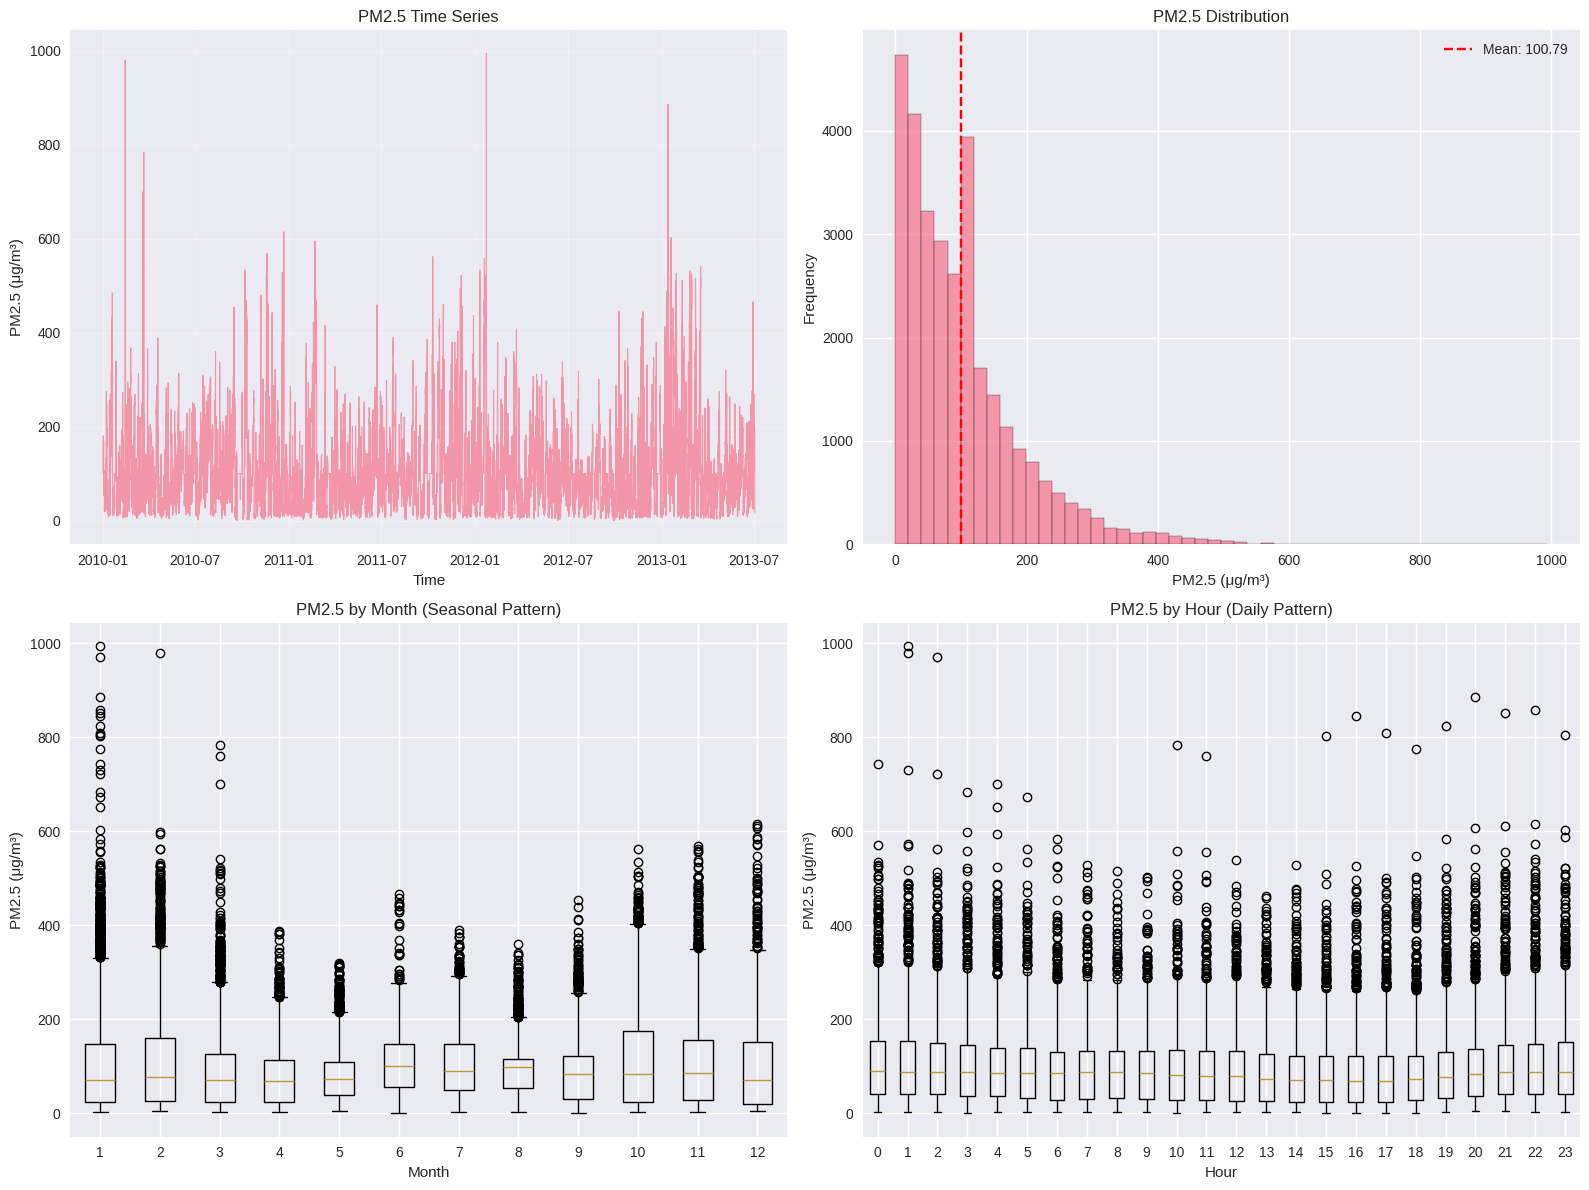

=== PM2.5 STATISTICAL SUMMARY ===
Mean: 100.79
Median: 81.00
Std: 90.18
Min: 0.00
Max: 994.00
Skewness: 1.87
Kurtosis: 5.64


In [31]:
# Comprehensive PM2.5 analysis
target_col = 'pm2.5'

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Time series plot
axes[0, 0].plot(df_train.index, df_train[target_col], alpha=0.7, linewidth=0.8)
axes[0, 0].set_title('PM2.5 Time Series')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('PM2.5 (μg/m³)')
axes[0, 0].grid(True, alpha=0.3)

# Distribution histogram
axes[0, 1].hist(df_train[target_col].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('PM2.5 Distribution')
axes[0, 1].set_xlabel('PM2.5 (μg/m³)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_train[target_col].mean(), color='red', linestyle='--', label=f'Mean: {df_train[target_col].mean():.2f}')
axes[0, 1].legend()

# Box plot by month (seasonal patterns)
monthly_data = df_train.groupby('month')[target_col].apply(list).to_dict()
axes[1, 0].boxplot([monthly_data[i] for i in range(1, 13)], labels=range(1, 13))
axes[1, 0].set_title('PM2.5 by Month (Seasonal Pattern)')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('PM2.5 (μg/m³)')

# Box plot by hour (daily pattern)
hourly_data = df_train.groupby('hour')[target_col].apply(list).to_dict()
axes[1, 1].boxplot([hourly_data[i] for i in range(24)], labels=range(24))
axes[1, 1].set_title('PM2.5 by Hour (Daily Pattern)')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('PM2.5 (μg/m³)')

plt.tight_layout()
plt.show()

# Statistical summary
print("=== PM2.5 STATISTICAL SUMMARY ===")
print(f"Mean: {df_train[target_col].mean():.2f}")
print(f"Median: {df_train[target_col].median():.2f}")
print(f"Std: {df_train[target_col].std():.2f}")
print(f"Min: {df_train[target_col].min():.2f}")
print(f"Max: {df_train[target_col].max():.2f}")
print(f"Skewness: {df_train[target_col].skew():.2f}")
print(f"Kurtosis: {df_train[target_col].kurtosis():.2f}")

**Explanation:** Target variable analysis reveals:

- `Temporal patterns:` Seasonal and daily cycles inform model architecture choices
- `Distribution shape:` Skewness suggests need for normalization or transformation
- `Outliers:` Extreme values that might need special handling
- `Seasonality:` Helps determine if seasonal decomposition is needed

## Feature Correlation Analysis



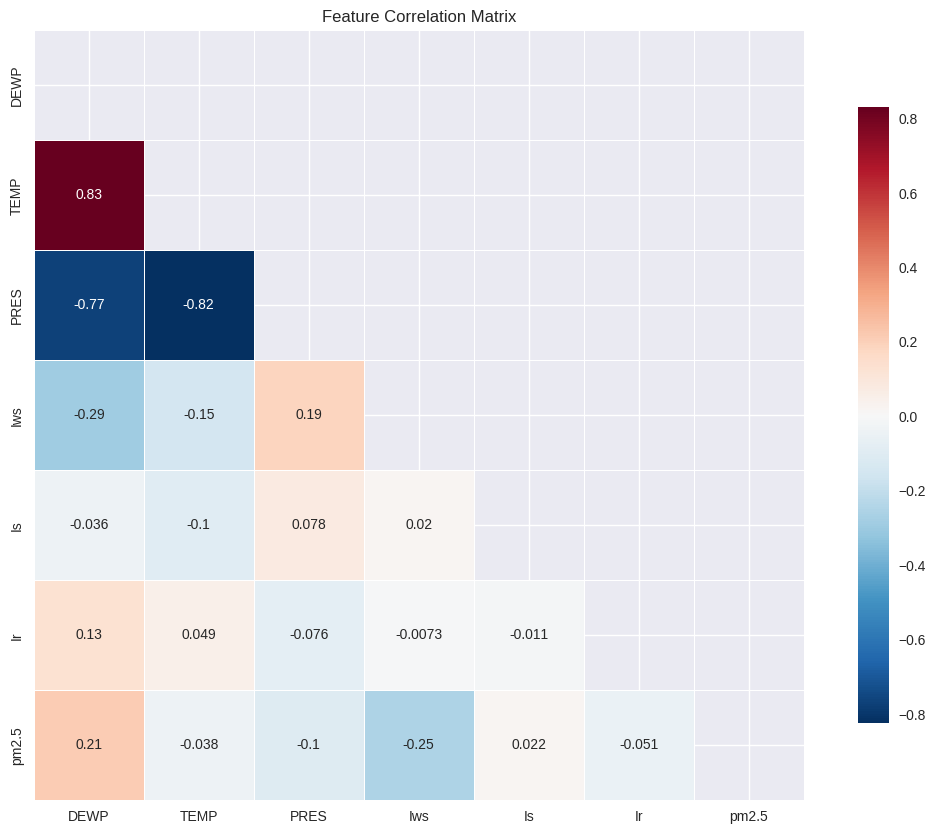

=== FEATURES CORRELATION WITH PM2.5 ===
Iws: 0.250
DEWP: 0.211
PRES: 0.105
Ir: 0.051
TEMP: 0.038
Is: 0.022


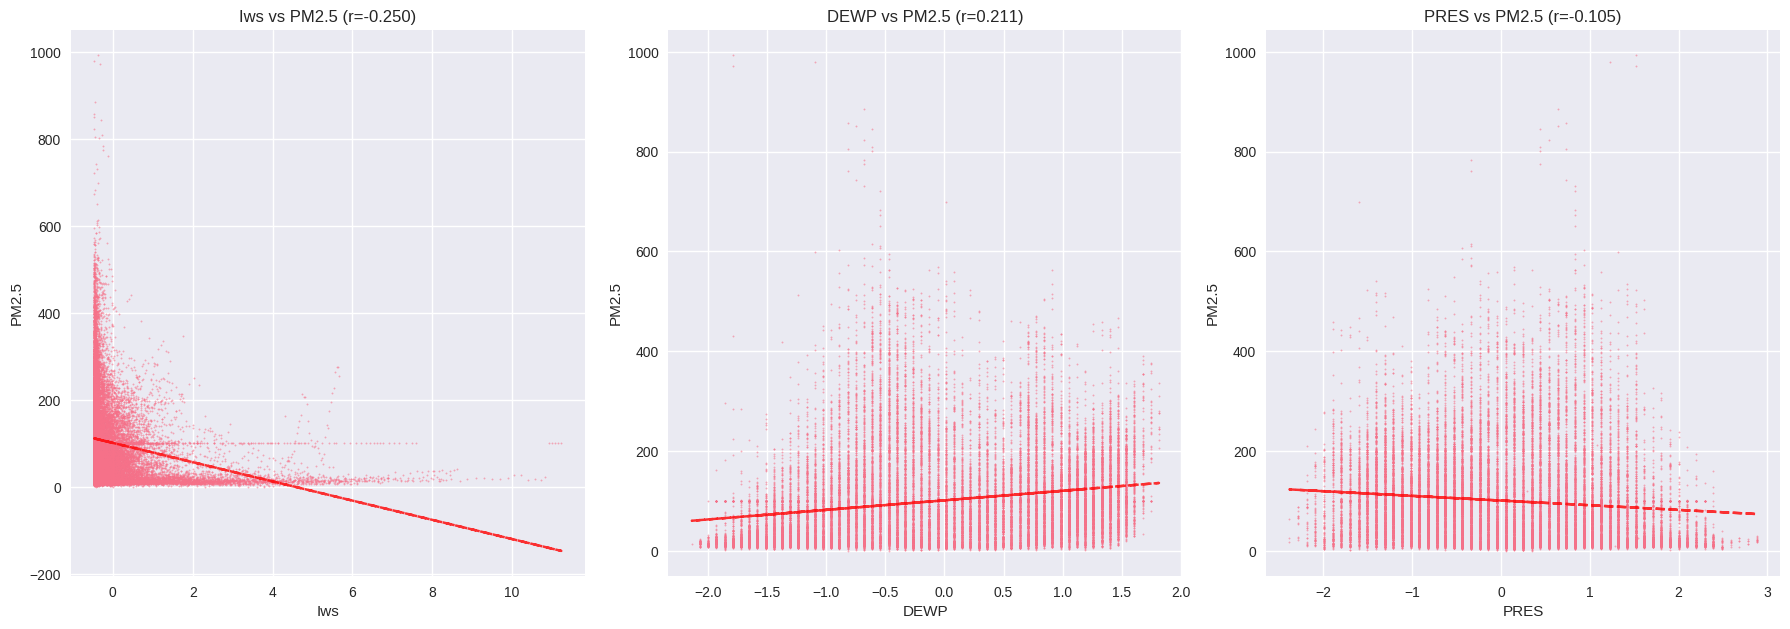

In [32]:
# Correlation analysis with target variable
numeric_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']
correlation_matrix = df_train[numeric_cols].corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.show()

# Target correlation ranking
target_corr = correlation_matrix[target_col].abs().sort_values(ascending=False)
print("=== FEATURES CORRELATION WITH PM2.5 ===")
for feature, corr in target_corr.items():
    if feature != target_col:
        print(f"{feature}: {corr:.3f}")

# Scatter plots for highly correlated features
high_corr_features = target_corr[target_corr > 0.1].index.tolist()
high_corr_features.remove(target_col)

if len(high_corr_features) > 0:
    n_features = min(6, len(high_corr_features))
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, feature in enumerate(high_corr_features[:n_features]):
        axes[i].scatter(df_train[feature], df_train[target_col], alpha=0.5, s=1)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('PM2.5')
        axes[i].set_title(f'{feature} vs PM2.5 (r={correlation_matrix.loc[feature, target_col]:.3f})')

        # Add trend line
        z = np.polyfit(df_train[feature].dropna(), df_train[target_col][df_train[feature].notna()], 1)
        p = np.poly1d(z)
        axes[i].plot(df_train[feature], p(df_train[feature]), "r--", alpha=0.8)

    # Hide unused subplots
    for i in range(n_features, 6):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

**Explanation:** Correlation analysis helps with:

- Feature selection: Highly correlated features are good predictors
- Multicollinearity detection: Prevents redundant features that can hurt model performance
- Relationship understanding: Linear vs non-linear relationships inform model choice

# Separate features and target


- Feel free to trop any non-essential columns like that you think might not contribute to modeling.


In [33]:
X_train = df_train.drop(['pm2.5', 'No'], axis=1)
y_train = df_train['pm2.5']

#  Feature Scaling and Normalization

Analyzing scaling impact on training features...


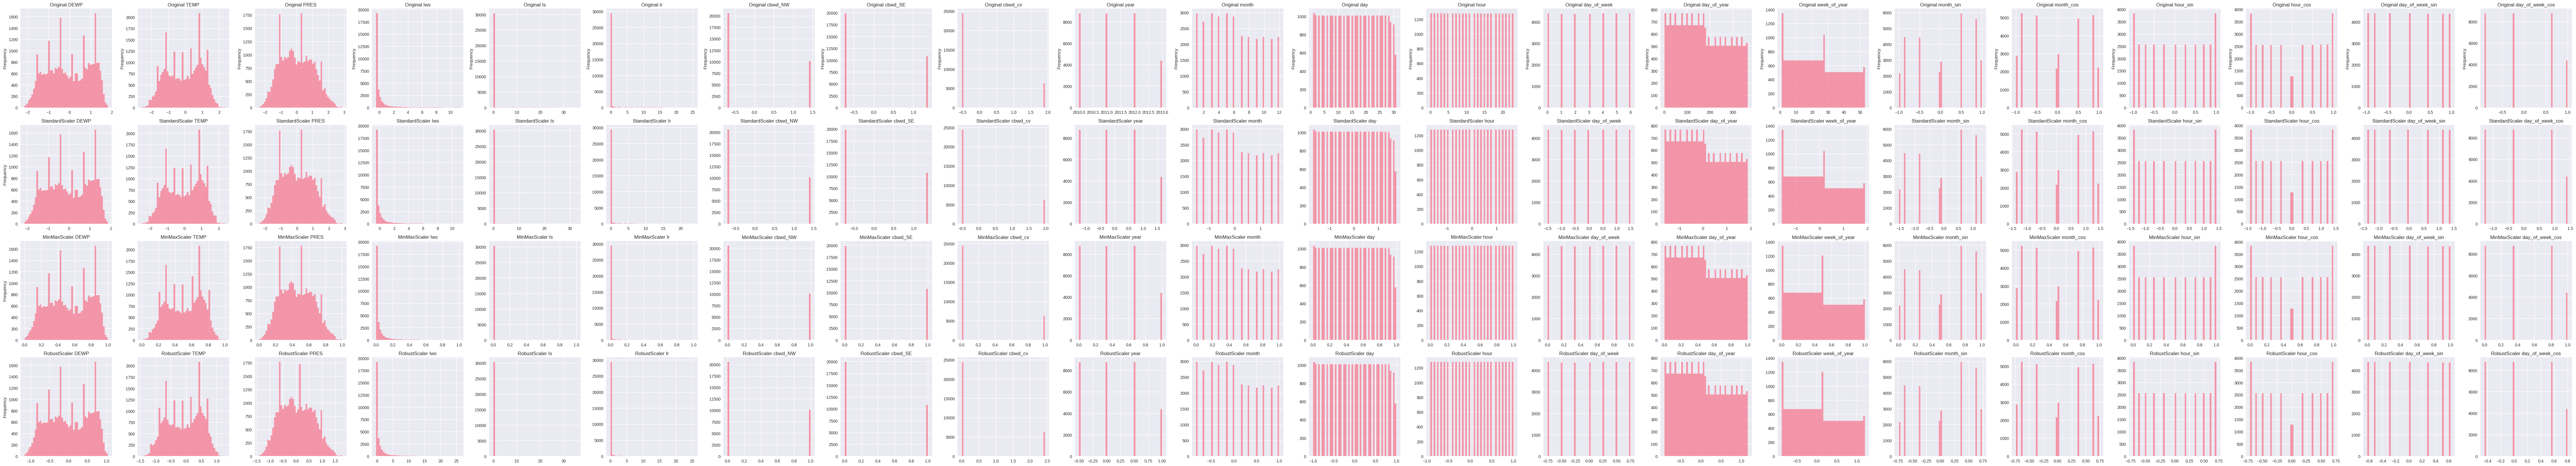

=== SCALING STATISTICS COMPARISON ===
Original Data:
               DEWP          TEMP          PRES           Iws            Is  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean      -0.029431     -0.062712      0.013612      0.030542      0.016992   
std        0.994087      1.015193      1.008991      1.018337      1.087278   
min       -2.135153     -2.578070     -2.380821     -0.468688     -0.069353   
25%       -0.888034     -0.938521     -0.822670     -0.441894     -0.069353   
50%       -0.056622      0.045209     -0.043595     -0.352512     -0.069353   
75%        0.913358      0.864984      0.832865      0.005216     -0.069353   
max        1.814055      2.340578      2.877939     11.231956     35.439859   

                 Ir       cbwd_NW       cbwd_SE       cbwd_cv          year  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.011253      0.016193      0.005833     -0.025008   2011.285826  

In [39]:
# Feature scaling analysis and implementation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def analyze_scaling_impact(X_data, feature_names=None):
    """
    Analyze the impact of different scaling methods on features
    """
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(X_data.shape[1])]

    scalers = {
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler()
    }

    # Convert to DataFrame for easier handling
    if isinstance(X_data, np.ndarray):
        df_features = pd.DataFrame(X_data, columns=feature_names)
    else:
        df_features = X_data.copy()
        feature_names = df_features.columns.tolist()

    n_features = len(feature_names)
    fig, axes = plt.subplots(len(scalers) + 1, n_features, figsize=(4*n_features, 16))

    # Handle single feature case
    if n_features == 1:
        axes = axes.reshape(-1, 1)

    # Original distributions
    for i, feature in enumerate(feature_names):
        axes[0, i].hist(df_features[feature].dropna(), bins=50, alpha=0.7)
        axes[0, i].set_title(f'Original {feature}')
        axes[0, i].set_ylabel('Frequency')

    # Scaled distributions
    for scaler_idx, (scaler_name, scaler) in enumerate(scalers.items()):
        scaled_data = scaler.fit_transform(df_features.dropna())
        scaled_df = pd.DataFrame(scaled_data, columns=feature_names)

        for i, feature in enumerate(feature_names):
            axes[scaler_idx + 1, i].hist(scaled_df[feature], bins=50, alpha=0.7)
            axes[scaler_idx + 1, i].set_title(f'{scaler_name} {feature}')
            if i == 0:
                axes[scaler_idx + 1, i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Statistics comparison
    print("=== SCALING STATISTICS COMPARISON ===")
    original_stats = df_features.describe()
    print("Original Data:")
    print(original_stats)

    for scaler_name, scaler in scalers.items():
        scaled_data = scaler.fit_transform(df_features.dropna())
        scaled_df = pd.DataFrame(scaled_data, columns=feature_names)
        print(f"\n{scaler_name}:")
        print(scaled_df.describe())

def scale_train_data(X_train, y_train, scaler_type='robust'):
    """
    Scale training data and return scalers for later use on test data

    Parameters:
    X_train: Training features (DataFrame or numpy array)
    y_train: Training target (Series or numpy array)
    scaler_type: 'standard', 'minmax', or 'robust'

    Returns:
    X_train_scaled, y_train_scaled, x_scaler, y_scaler
    """

    # Choose scaler type
    scaler_options = {
        'standard': StandardScaler(),
        'minmax': MinMaxScaler(),
        'robust': RobustScaler()
    }

    x_scaler = scaler_options[scaler_type]
    y_scaler = StandardScaler()  # Usually StandardScaler for target

    # Scale features
    X_train_scaled = x_scaler.fit_transform(X_train)

    # Handle target scaling - convert to numpy array first if it's a pandas Series
    if hasattr(y_train, 'values'):
        # It's a pandas Series or DataFrame
        y_train_array = y_train.values
    else:
        # It's already a numpy array
        y_train_array = y_train

    # Scale target (reshape to 2D for scaler)
    if y_train_array.ndim == 1:
        y_train_reshaped = y_train_array.reshape(-1, 1)
    else:
        y_train_reshaped = y_train_array

    y_train_scaled = y_scaler.fit_transform(y_train_reshaped)

    # If original y_train was 1D, flatten the scaled version
    if y_train_array.ndim == 1:
        y_train_scaled = y_train_scaled.flatten()

    print(f"=== SCALING APPLIED ===")
    print(f"X_scaler: {type(x_scaler).__name__}")
    print(f"y_scaler: {type(y_scaler).__name__}")
    print(f"X_train shape: {X_train.shape} -> {X_train_scaled.shape}")
    print(f"y_train shape: {y_train.shape} -> {y_train_scaled.shape}")

    return X_train_scaled, y_train_scaled, x_scaler, y_scaler


# Example usage (assuming you have X_train and y_train ready):
# First, analyze scaling impact on your features
print("Analyzing scaling impact on training features...")
analyze_scaling_impact(X_train, feature_names=['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'other_features...'])

# Apply scaling to your training data
X_train_scaled, y_train_scaled, x_scaler, y_scaler = scale_train_data(X_train, y_train, scaler_type='robust')

print("\n=== SCALING CHOICE EXPLANATION ===")
print("RobustScaler chosen for features because:")
print("- Uses median and IQR instead of mean and std")
print("- Less sensitive to outliers")
print("- Better for time series with seasonal variations")
print("- Preserves the relative relationships between features")
print("\nStandardScaler chosen for target because:")
print("- Ensures target values are centered around 0")
print("- Helps with model convergence and gradient stability")
print("- Easy to inverse transform for final predictions")

# Function to scale test data using fitted scalers
def scale_test_data(X_test, y_test, x_scaler, y_scaler):
    """
    Scale test data using pre-fitted scalers
    """
    X_test_scaled = x_scaler.transform(X_test)

    if y_test.ndim == 1:
        y_test_reshaped = y_test.reshape(-1, 1)
    else:
        y_test_reshaped = y_test

    y_test_scaled = y_scaler.transform(y_test_reshaped)

    if y_test.ndim == 1:
        y_test_scaled = y_test_scaled.flatten()

    return X_test_scaled, y_test_scaled

# Function to inverse transform predictions
def inverse_transform_predictions(y_pred_scaled, y_scaler):
    """
    Convert scaled predictions back to original scale
    """
    if y_pred_scaled.ndim == 1:
        y_pred_reshaped = y_pred_scaled.reshape(-1, 1)
    else:
        y_pred_reshaped = y_pred_scaled

    y_pred_original = y_scaler.inverse_transform(y_pred_reshaped)

    if y_pred_scaled.ndim == 1:
        y_pred_original = y_pred_original.flatten()

    return y_pred_original

In [40]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)

In [41]:
# Train-test split for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42
)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [42]:
model = Sequential()
model.add(InputLayer((X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(
    Bidirectional(
        LSTM(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.15)
    )
)
model.add(
    Bidirectional(
        LSTM(64, return_sequences=False, dropout=0.25, recurrent_dropout=0.15)
    )
)
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1))

model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0005),
    metrics=[RootMeanSquaredError()]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       154,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,577 (1.23 MB)

 Trainable params: 321,577 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-5),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=100, batch_size=128, callbacks=callbacks)

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - loss: 0.9013 - root_mean_squared_error: 0.9487 - val_loss: 0.6445 - val_root_mean_squared_error: 0.8028 - learning_rate: 5.0000e-04
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.7100 - root_mean_squared_error: 0.8426 - val_loss: 0.6074 - val_root_mean_squared_error: 0.7794 - learning_rate: 5.0000e-04
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.6983 - root_mean_squared_error: 0.8356 - val_loss: 0.5766 - val_root_mean_squared_error: 0.7594 - learning_rate: 5.0000e-04
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.6816 - root_mean_squared_error: 0.8256 - val_loss: 0.5609 - val_root_mean_squared_error: 0.7490 - learning_rate: 5.0000e-04
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.6555 - root_mean_squared_error: 0.8095 - val_loss: 0.5555 - val_root_mean_squared_error: 0.7454 - learning_rate: 5.0000e-04
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - l

959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


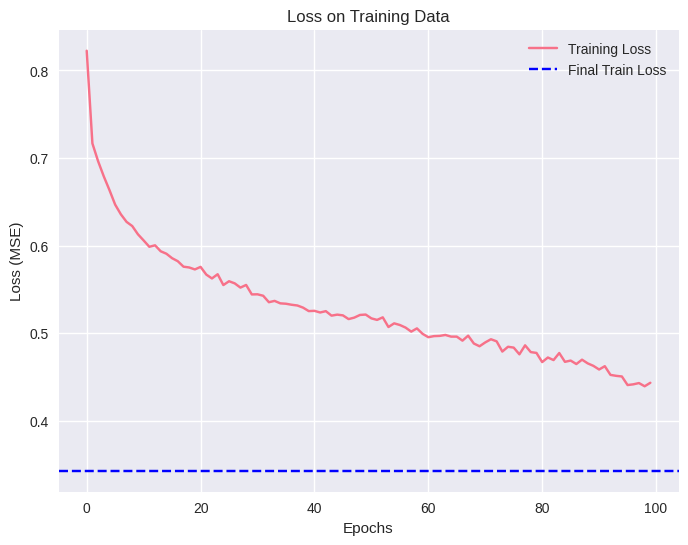

Final Training Loss (MSE): 0.3427316750125007


In [44]:
# Calculate training loss
train_predictions = model.predict(X_train_scaled)  # Use scaled X data
train_loss = np.mean((y_train_scaled - train_predictions.flatten())**2)  # Use scaled y data

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Train Loss')  # Fixed typo: "rain" -> "Train"
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [46]:
# Prepare test data
X_test = df_test.drop(['No'], axis=1)
X_test_scaled = x_scaler.transform(X_test)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test_scaled)

# transform to correct scale
predictions = y_scaler.inverse_transform(predictions)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(df_test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
